#### Container einrichten, erstellen und starten

In [12]:
!docker run --name some-postgres -e POSTGRES_PASSWORD=mysecretpassword -d -p 5432:5432 postgres


137d0de6d18e957c8c842de3093cb2e7fdce1df126a21d9d20f91e7abae2c792


#### Falls bereits eingerichtet:

In [ ]:
docker start some-postgres

#### Überprüfen, ob der Container läuft

In [27]:
!docker ps

CONTAINER ID   IMAGE      COMMAND                  CREATED          STATUS          PORTS                    NAMES
137d0de6d18e   postgres   "docker-entrypoint.sâ€¦"   18 minutes ago   Up 18 minutes   0.0.0.0:5432->5432/tcp   some-postgres


#### psycopg2-binary: Ein PostgreSQL-Adapter für Python. 
#### requests: Eine Bibliothek zum einfachen Abrufen von Daten über HTTP. 
#### pandas, matplot, seaborn: Eine Datenmanipulationsbibliothek, ideal für die Arbeit mit tabellarischen Daten.

In [5]:
!pip install psycopg2-binary pandas matplotlib seaborn requests


### API für Bevölkerungspopulation

In [ ]:
url_population = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/demo_r_d2jan?format=JSON&time=2019&time=2020&time=2021&time=2022&time=2023&geo=AT&geo=AT1&geo=AT11&geo=AT12&geo=AT13&geo=AT2&geo=AT21&geo=AT22&geo=AT3&geo=AT31&geo=AT32&geo=AT33&geo=AT34&unit=NR&sex=T&age=TOTAL&lang=en"

### API für Tierpopulation

In [ ]:
url_animal_population = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/agr_r_animal?format=JSON&time=2019&time=2020&time=2021&time=2022&time=2023&geo=AT&geo=AT1&geo=AT11&geo=AT12&geo=AT13&geo=AT2&geo=AT21&geo=AT22&geo=AT3&geo=AT31&geo=AT32&geo=AT33&geo=AT34&unit=THS_HD&animals=A2000&animals=A2300&animals=A2300F&animals=A2300G&animals=A2400&animals=A2420&animals=A3100&animals=A3120_3133&animals=A4100&animals=A4120&animals=A4200&animals=A4220&lang=en"

#### Verbindung zur Datenbank in Python aufbauen

In [26]:
import psycopg2

try:
    conn = psycopg2.connect(
        dbname="postgres",  # Standardmäßiger Datenbankname
        user="postgres",    # Standardmäßiger Benutzername
        password="mysecretpassword",  # Passwort, das du beim Starten des Containers festgelegt wurde
        host="localhost",   # Port wurde weitergeleitet und kann über localhost verwendet werden
        port="5432"         # Standard-PostgreSQL-Port
    )
    print("Verbindung erfolgreich")
except Exception as e:
    print("Verbindung fehlgeschlagen:")
    print(e)

Verbindung erfolgreich


## Bevölkerungs API abrufen

In [13]:
import requests

# API abrufen
url_population = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/demo_r_d2jan?format=JSON&time=2019&time=2020&time=2021&time=2022&time=2023&geo=AT&geo=AT1&geo=AT11&geo=AT12&geo=AT13&geo=AT2&geo=AT21&geo=AT22&geo=AT3&geo=AT31&geo=AT32&geo=AT33&geo=AT34&unit=NR&sex=T&age=TOTAL&lang=en"
response = requests.get(url_population)
data = response.json()

# Überprüfen der Datenstruktur
print(data.keys())


dict_keys(['version', 'class', 'label', 'source', 'updated', 'value', 'id', 'size', 'dimension', 'extension'])


In [15]:
# Extraktion von GeoCode und Year Informationen, falls verfügbar
geocodes = data['dimension']['geo']['category']['label'].keys()
years = data['dimension']['time']['category']['label'].keys()

# Erstellen eines DataFrames
df = pd.DataFrame({
    'GeoCode': list(geocodes) * len(years),
    'Year': list(years) * len(geocodes),
    'Population': list(data['value'].values())
})

print(df.head())


  GeoCode  Year  Population
0      AT  2019     8858775
1     AT1  2020     8901064
2    AT11  2021     8932664
3    AT12  2022     8978929
4    AT13  2023     9104772


In [17]:
# Statistische Zusammenfassung der Bevölkerungsdaten
print(df.describe())

# Anzahl der Bevölkerungsdaten pro GeoCode und Jahr
print(df.groupby(['GeoCode', 'Year']).size())


         Population
count  6.500000e+01
mean   2.066594e+06
std    2.263501e+06
min    2.934330e+05
25%    5.626060e+05
50%    1.495608e+06
75%    1.931593e+06
max    9.104772e+06
GeoCode  Year
AT       2019    1
         2020    1
         2021    1
         2022    1
         2023    1
                ..
AT34     2019    1
         2020    1
         2021    1
         2022    1
         2023    1
Length: 65, dtype: int64


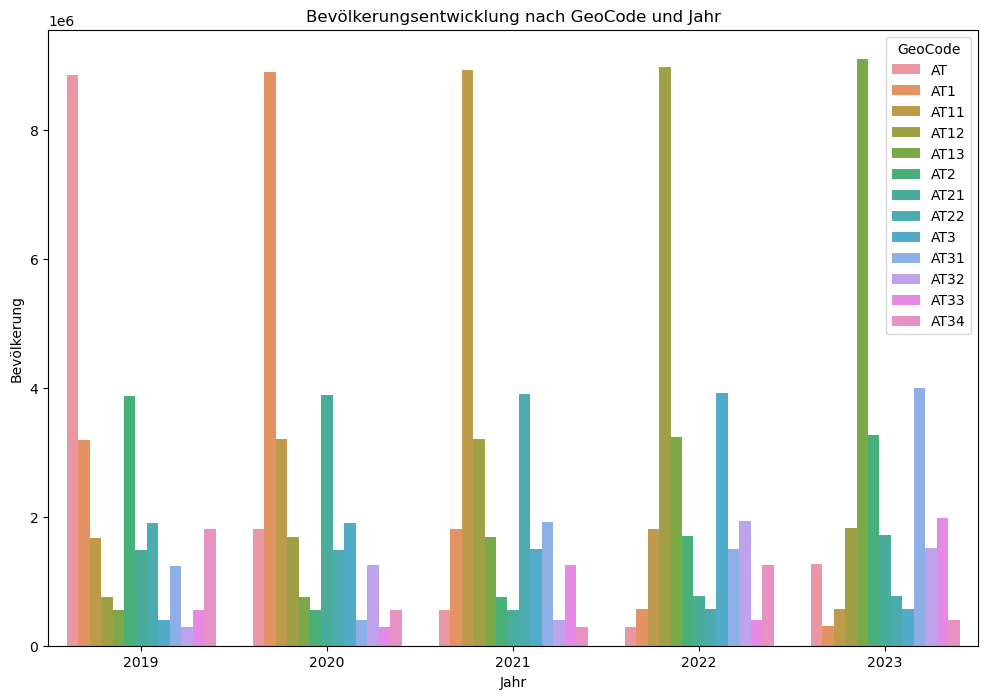

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Erstellen eines Balkendiagramms zur Visualisierung der Bevölkerung nach GeoCode und Jahr
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='Year', y='Population', hue='GeoCode')
plt.title('Bevölkerungsentwicklung nach GeoCode und Jahr')
plt.xlabel('Jahr')
plt.ylabel('Bevölkerung')
plt.legend(title='GeoCode')
plt.show()


C:\Users\smurh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\smurh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


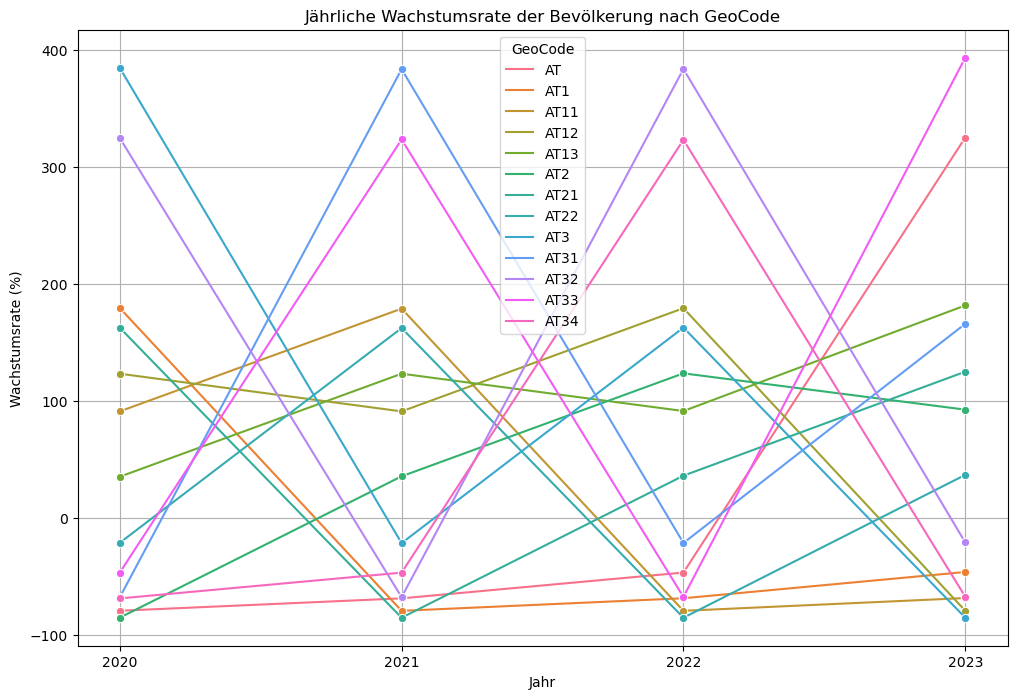

In [19]:
# Berechnung der jährlichen Wachstumsrate der Bevölkerung pro GeoCode
df_sorted = df.sort_values(by=['GeoCode', 'Year'])
df_sorted['Population_Growth'] = df_sorted.groupby('GeoCode')['Population'].pct_change() * 100

# Visualisierung der Wachstumsraten
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_sorted, x='Year', y='Population_Growth', hue='GeoCode', marker='o')
plt.title('Jährliche Wachstumsrate der Bevölkerung nach GeoCode')
plt.xlabel('Jahr')
plt.ylabel('Wachstumsrate (%)')
plt.grid(True)
plt.show()


## Tierbevölkerungs API abrufen

In [21]:
import requests

# API für Tierbevölkerungsdaten
url_animal_population = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/agr_r_animal?format=JSON&time=2019&time=2020&time=2021&time=2022&time=2023&geo=AT&geo=AT1&geo=AT11&geo=AT12&geo=AT13&geo=AT2&geo=AT21&geo=AT22&geo=AT3&geo=AT31&geo=AT32&geo=AT33&geo=AT34&unit=THS_HD&animals=A2000&animals=A2300&animals=A2300F&animals=A2300G&animals=A2400&animals=A2420&animals=A3100&animals=A3120_3133&animals=A4100&animals=A4120&animals=A4200&animals=A4220&lang=en"
response = requests.get(url_animal_population)
data = response.json()

# Überprüfen der Datenstruktur
print(data.keys())


dict_keys(['version', 'class', 'label', 'source', 'updated', 'value', 'status', 'id', 'size', 'dimension', 'extension'])


In [22]:
# Datenwerte und Dimensionen extrahieren
values = data['value']
dimensions = data['dimension']

# Zeige die ersten Einträge in 'values' und die Schlüssel von 'dimensions'
print(list(values.items())[:5])
print(dimensions.keys())


[('0', 1879.52), ('1', 1855.43), ('2', 1870.1), ('3', 1861.07), ('5', 438.43)]
dict_keys(['freq', 'animals', 'unit', 'geo', 'time'])


In [24]:
# Umwandlung von Schlüsseln in Listen für einfache Indizierung
geocode_list = list(geocodes.values())
year_list = list(years.values())

# Vorbereitung des DataFrame
import pandas as pd

data_entries = []
for key, value in values.items():
    geocode_index = int(key) % len(geocode_list)  # Angenommene zyklische Wiederholung
    year_index = int(key) // len(geocode_list) % len(year_list)
    data_entries.append({
        'Year': year_list[year_index],
        'GeoCode': geocode_list[geocode_index],
        'Population': value
    })

df = pd.DataFrame(data_entries)
print(df.head())



   Year           GeoCode  Population
0  2019           Austria     1879.52
1  2019     Ostösterreich     1855.43
2  2019        Burgenland     1870.10
3  2019  Niederösterreich     1861.07
4  2019     Südösterreich      438.43


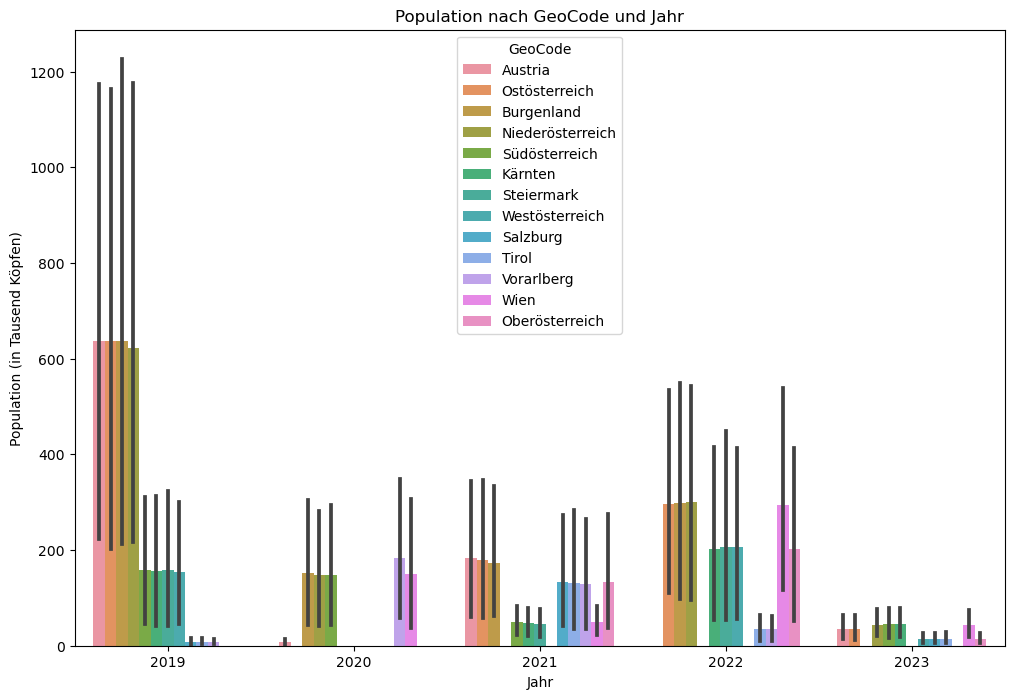

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualisierung der Bevölkerung (oder Tierpopulation) nach GeoCode und Jahr
plt.figure(figsize=(12, 8))
sns.barplot(data=df, x='Year', y='Population', hue='GeoCode')
plt.title('Population nach GeoCode und Jahr')
plt.xlabel('Jahr')
plt.ylabel('Population (in Tausend Köpfen)')
plt.legend(title='GeoCode')
plt.show()
